In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('all_shots_v5.csv')

In [3]:
df.head()

,Unnamed: 0,Shot Distance,X Location,Y Location,Away Team,Season Type,Year,Shot Zone Basic_Above the Break 3,Shot Zone Basic_Backcourt,Shot Zone Basic_In The Paint (Non-RA),...,PG-SG,SF,SF-SG,SG,SG-PG,E_DEF_RATING,E_OFF_RATING,PCT_PREV_ACTION,PCT_AREA,YEARS_EXP
0,0,19.0,-107.0,167.0,PHI,0.0,2000.0,False,False,False,...,0.0,0.0,0.0,1.0,0.0,95.5,100.7,56.465873,35.089974,3.0
1,1,21.0,-115.0,177.0,PHI,0.0,2000.0,False,False,False,...,0.0,0.0,0.0,1.0,0.0,95.5,100.7,56.465873,35.089974,3.0
2,2,16.0,165.0,13.0,PHI,0.0,2000.0,False,False,False,...,0.0,0.0,0.0,1.0,0.0,95.5,100.7,56.465873,35.089974,3.0
3,3,15.0,0.0,150.0,PHI,0.0,2000.0,False,False,False,...,0.0,0.0,0.0,1.0,0.0,95.5,100.7,56.465873,0.749611,3.0
4,4,15.0,0.0,150.0,PHI,0.0,2000.0,False,False,False,...,0.0,0.0,0.0,1.0,0.0,95.5,100.7,76.724138,0.749611,3.0


In [4]:
df.columns

Index(['Unnamed: 0', 'Shot Distance', 'X Location', 'Y Location', 'Away Team',
       'Season Type', 'Year', 'Shot Zone Basic_Above the Break 3',
       'Shot Zone Basic_Backcourt', 'Shot Zone Basic_In The Paint (Non-RA)',
       'Shot Zone Basic_Left Corner 3', 'Shot Zone Basic_Mid-Range',
       'Shot Zone Basic_Restricted Area', 'Shot Zone Basic_Right Corner 3',
       'Shot Zone Area_Back Court(BC)', 'Shot Zone Area_Center(C)',
       'Shot Zone Area_Left Side Center(LC)', 'Shot Zone Area_Left Side(L)',
       'Shot Zone Area_Right Side Center(RC)', 'Shot Zone Area_Right Side(R)',
       'Shot Zone Range_16-24 ft.', 'Shot Zone Range_24+ ft.',
       'Shot Zone Range_8-16 ft.', 'Shot Zone Range_Back Court Shot',
       'Shot Zone Range_Less Than 8 ft.', 'GAME_ID', 'EVENTNUM', 'target',
       'PERIOD', 'PLAYER1_NAME', 'PLAYER1_TEAM_ABBREVIATION', 'OPPONENT_TEAM',
       'at_home', 'PREVIOUS_OFF_REBOUND', 'PREVIOUS_DEF_REBOUND',
       'PREVIOUS_OFF_TURNOVER', 'PREVIOUS_OFF_MISSED', 

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439450 entries, 0 to 439449
Data columns (total 78 columns):
 #   Column                                 Non-Null Count   Dtype  
---  ------                                 --------------   -----  
 0   Unnamed: 0                             439450 non-null  int64  
 1   Shot Distance                          439450 non-null  float64
 2   X Location                             439450 non-null  float64
 3   Y Location                             439450 non-null  float64
 4   Away Team                              439450 non-null  object 
 5   Season Type                            439450 non-null  float64
 6   Year                                   439450 non-null  float64
 7   Shot Zone Basic_Above the Break 3      439450 non-null  bool   
 8   Shot Zone Basic_Backcourt              439450 non-null  bool   
 9   Shot Zone Basic_In The Paint (Non-RA)  439450 non-null  bool   
 10  Shot Zone Basic_Left Corner 3          439450 non-null  

**::::::::::::::::::::::: LeNet + XGBoost :::::::::::::::::::::::::**

In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, MaxPooling1D, Input
import xgboost as xgb

# Step 1: Preprocessing (same as before)
df_updated = df.drop(columns=['Unnamed: 0', 'year_start', 'year_end'])
df_updated['GAME_ID_EVENTNUM'] = df_updated['GAME_ID'].astype(str) + '_' + df_updated['EVENTNUM'].astype(str)
df_updated.set_index('GAME_ID_EVENTNUM', inplace=True)
df_updated = df_updated.drop(columns=['GAME_ID', 'EVENTNUM'])

X = df_updated.drop(columns=['target'])
y = df_updated['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
    ])

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Reshape for Conv1D
X_train_transformed = X_train_transformed.reshape((X_train_transformed.shape[0], X_train_transformed.shape[1], 1))
X_test_transformed = X_test_transformed.reshape((X_test_transformed.shape[0], X_test_transformed.shape[1], 1))

# Step 2: Build LeNet Model (Feature Extraction)
lenet_model = Sequential([
    Input(shape=(X_train_transformed.shape[1], 1)),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),  # Dense layer without final classification
    Dropout(0.5),
])

# Extract features from LeNet
features_train = lenet_model.predict(X_train_transformed)
features_test = lenet_model.predict(X_test_transformed)

# Step 3: Train XGBoost on extracted features
xgb_model = xgb.XGBClassifier()
xgb_model.fit(features_train, y_train)

# Step 4: Evaluate the hybrid model on test data
xgb_test_acc = xgb_model.score(features_test, y_test)
print(f"XGBoost Test Accuracy: {xgb_test_acc}")

# Step 5: Evaluate the hybrid model on training data (for training accuracy)
xgb_train_acc = xgb_model.score(features_train, y_train)
print(f"XGBoost Training Accuracy: {xgb_train_acc}")


10987/10987 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step
2747/2747 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
XGBoost Test Accuracy: 0.6681078621003527
XGBoost Training Accuracy: 0.7105700307202184


In [7]:
from sklearn.metrics import confusion_matrix, classification_report

# Step 6: Make predictions on the test set
y_pred_test = xgb_model.predict(features_test)

# Step 7: Compute confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

# Step 8: Compute classification report
class_report = classification_report(y_test, y_pred_test)
print("\nClassification Report:")
print(class_report)



Confusion Matrix:
[[24491 13732]
 [15438 34229]]

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.64      0.63     38223
           1       0.71      0.69      0.70     49667

    accuracy                           0.67     87890
   macro avg       0.66      0.66      0.66     87890
weighted avg       0.67      0.67      0.67     87890



**=============================>>>> optimization : LeNet+XGBoost**

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Dropout, MaxPooling1D, Input
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Drop unnecessary columns and create new index
df_updated = df.drop(columns=['Unnamed: 0', 'year_start', 'year_end'])
df_updated['GAME_ID_EVENTNUM'] = df_updated['GAME_ID'].astype(str) + '_' + df_updated['EVENTNUM'].astype(str)
df_updated.set_index('GAME_ID_EVENTNUM', inplace=True)
df_updated = df_updated.drop(columns=['GAME_ID', 'EVENTNUM'])

# Step 2: Separate target and features
X = df_updated.drop(columns=['target'])
y = df_updated['target']

# Step 3: Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Identify categorical and numerical columns
categorical_columns = X_train.select_dtypes(include=['object']).columns.tolist()
numeric_columns = X_train.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Step 5: Apply preprocessing (OneHotEncoding for categorical and scaling for numeric)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_columns)
    ])

# Step 6: Transform the data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Step 7: Reshape the data for Conv1D (LeNet part)
X_train_transformed = X_train_transformed.reshape((X_train_transformed.shape[0], X_train_transformed.shape[1], 1))
X_test_transformed = X_test_transformed.reshape((X_test_transformed.shape[0], X_test_transformed.shape[1], 1))

# Step 8: Build the LeNet model (Conv1D)
model = Sequential([
    Input(shape=(X_train_transformed.shape[1], 1)),  # Define the shape explicitly
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.6),  # Increased dropout to reduce overfitting
    Dense(1, activation='sigmoid')  # For binary classification
])

# Step 9: Compile the LeNet model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Step 10: Train the LeNet model
history = model.fit(X_train_transformed, y_train, epochs=100, batch_size=32, validation_data=(X_test_transformed, y_test))

# Step 11: Extract features from LeNet's penultimate layer (before final Dense layer)
feature_extractor = Sequential(model.layers[:-2])  # Remove the last two layers (dense and dropout)
features_train = feature_extractor.predict(X_train_transformed)
features_test = feature_extractor.predict(X_test_transformed)

# Step 12: Build and train the XGBoost model
xgb_params = {
    'max_depth': 4,  # Shallower trees
    'learning_rate': 0.01,  # Lower learning rate
    'n_estimators': 1000,  # More trees
    'subsample': 0.8,  # Randomly sample 80% of data for each tree
    'colsample_bytree': 0.8,  # Randomly sample 80% of features for each tree
    'lambda': 1,  # L2 regularization
    'alpha': 1,   # L1 regularization
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 42
}

xgb_model = xgb.XGBClassifier(**xgb_params)

# Step 13: Use early stopping and train XGBoost
eval_set = [(features_train, y_train), (features_test, y_test)]
xgb_model.fit(features_train, y_train, eval_set=eval_set, early_stopping_rounds=50, verbose=True)

# Step 14: Evaluate the XGBoost model
y_pred_test = xgb_model.predict(features_test)
y_pred_train = xgb_model.predict(features_train)

test_acc = accuracy_score(y_test, y_pred_test)
train_acc = accuracy_score(y_train, y_pred_train)

print(f"XGBoost Test Accuracy: {test_acc}")
print(f"XGBoost Training Accuracy: {train_acc}")

# Step 15: Display Confusion Matrix and Classification Report
conf_matrix = confusion_matrix(y_test, y_pred_test)
class_report = classification_report(y_test, y_pred_test)

print("Confusion Matrix:")
print(conf_matrix)

print("\nClassification Report:")
print(class_report)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Cross-validation for better generalization (Optional Step 16)
scores = cross_val_score(xgb_model, features_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy: {scores.mean()}")


Epoch 1/100
10987/10987 ━━━━━━━━━━━━━━━━━━━━ 88s 8ms/step - accuracy: 0.6724 - loss: 0.6028 - val_accuracy: 0.6832 - val_loss: 0.5923
Epoch 2/100
10987/10987 ━━━━━━━━━━━━━━━━━━━━ 89s 8ms/step - accuracy: 0.6826 - loss: 0.5945 - val_accuracy: 0.6852 - val_loss: 0.5880
Epoch 3/100
10987/10987 ━━━━━━━━━━━━━━━━━━━━ 84s 8ms/step - accuracy: 0.6854 - loss: 0.5913 - val_accuracy: 0.6857 - val_loss: 0.5872
Epoch 4/100
10987/10987 ━━━━━━━━━━━━━━━━━━━━ 99s 9ms/step - accuracy: 0.6859 - loss: 0.5899 - val_accuracy: 0.6876 - val_loss: 0.5859
Epoch 5/100
10987/10987 ━━━━━━━━━━━━━━━━━━━━ 105s 10ms/step - accuracy: 0.6877 - loss: 0.5881 - val_accuracy: 0.6869 - val_loss: 0.5841
Epoch 6/100
10987/10987 ━━━━━━━━━━━━━━━━━━━━ 107s 10ms/step - accuracy: 0.6890 - loss: 0.5862 - val_accuracy: 0.6889 - val_loss: 0.5862
Epoch 7/100
10987/10987 ━━━━━━━━━━━━━━━━━━━━ 109s 10ms/step - accuracy: 0.6904 - loss: 0.5856 - val_accuracy: 0.6916 - val_loss: 0.5807
Epoch 8/100
10987/10987 ━━━━━━━━━━━━━━━━━━━━ 108s 10ms/s

TypeError: XGBClassifier.fit() got an unexpected keyword argument 'early_stopping_rounds'

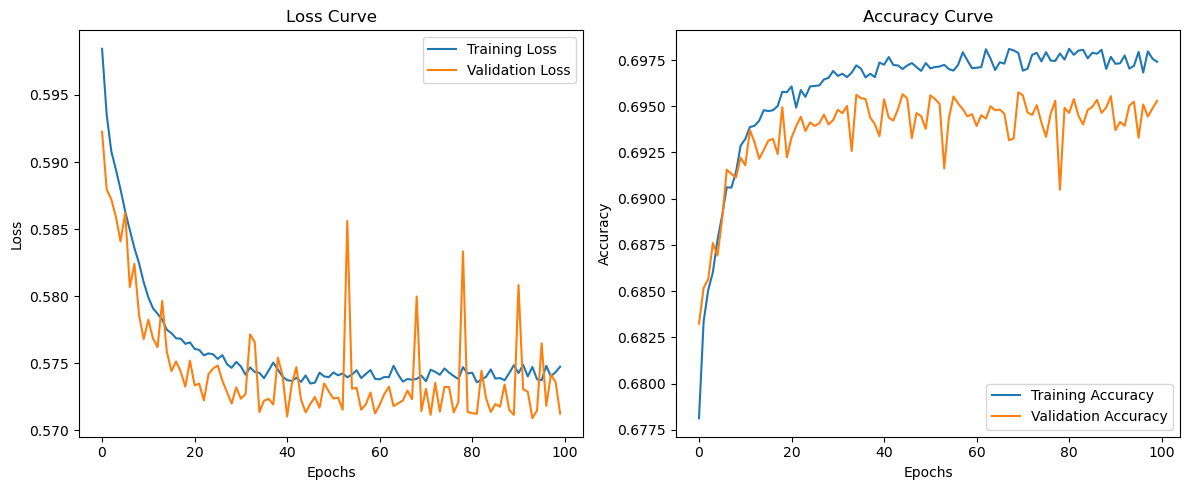

In [9]:
import matplotlib.pyplot as plt

# Retrieve loss and accuracy values from history
loss = history.history['loss']  # Training loss
val_loss = history.history['val_loss']  # Validation loss
accuracy = history.history['accuracy']  # Training accuracy
val_accuracy = history.history['val_accuracy']  # Validation accuracy

# Create a figure with two subplots: one for loss and one for accuracy
plt.figure(figsize=(12, 5))

# Plot Loss (Cost) curve
plt.subplot(1, 2, 1)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [10]:
from sklearn.metrics import classification_report

# Step 1: Predict on the test set
y_pred = model.predict(X_test_transformed)
y_pred_classes = np.round(y_pred)  # Convert probabilities to binary 0 or 1

# Step 2: Generate the classification report
report = classification_report(y_test, y_pred_classes, target_names=['Class 0', 'Class 1'])

# Step 3: Print the classification report
print(report)

2747/2747 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step
              precision    recall  f1-score   support

     Class 0       0.65      0.65      0.65     38223
     Class 1       0.73      0.73      0.73     49667

    accuracy                           0.70     87890
   macro avg       0.69      0.69      0.69     87890
weighted avg       0.70      0.70      0.70     87890

